In [1]:
import pandas as pd

# Read the UTF-8 CSV file
df = pd.read_csv('raw_kcc_data.csv', encoding='utf-8')

In [2]:
df.head()

,StateName,DistrictName,BlockName,Season,Sector,Category,Crop,QueryType,QueryText,KccAns,CreatedOn,year,month
0,KARNATAKA,CHITRADURGA,HIRIYUR,NaN,HORTICULTURE,Fruits,Papaya,Cultural Practices,papaya sowing time ?,June-September is the best season for planting...,04-01-2025 11:24,2025,1
1,KARNATAKA,CHITRADURGA,HOSDURGA,NaN,AGRICULTURE,Millets,FingerMillet (Ragi/Mandika),Weather,Asked about weather for irrigation\n,ನಿಮ್ಮ ತಾಲೂಕಿನಲ್ಲಿ ಇಂದು (4%). ಹೆಚ್ಚಿನ ಮಾಹಿತಿಗೆ...,10-01-2025 09:27,2025,1
2,KARNATAKA,CHITRADURGA,HOLALKERE,NaN,AGRICULTURE,Others,Others,Government Schemes,Asked about PM kisan samman nidhi yojana \n,--Not Eligible\n11th installment payment stopp...,10-01-2025 10:05,2025,1
3,KARNATAKA,CHITRADURGA,CHALLAKERE,NaN,AGRICULTURE,Others,Others,Government Schemes,Asked about PM kisan samman nidhi yojana- frui...,"ಅಗತ್ಯ ಮಾಹಿತಿ ನೀಡಿ ,ರೈತ ಸಂಪರ್ಕ ಕೇಂದ್ರವನ್ನು ಸಂಪರ...",11-01-2025 08:58,2025,1
4,KARNATAKA,CHITRADURGA,CHALLAKERE,NaN,AGRICULTURE,Others,Others,Government Schemes,Asked about Government Schemes\n,Given necessary information to farmer and sugg...,11-01-2025 16:10,2025,1


In [3]:
df.shape


(17118, 13)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17118 entries, 0 to 17117
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   StateName     17118 non-null  object 
 1   DistrictName  17118 non-null  object 
 2   BlockName     17070 non-null  object 
 3   Season        0 non-null      float64
 4   Sector        17118 non-null  object 
 5   Category      17118 non-null  object 
 6   Crop          17118 non-null  object 
 7   QueryType     17118 non-null  object 
 8   QueryText     17118 non-null  object 
 9   KccAns        17114 non-null  object 
 10  CreatedOn     17118 non-null  object 
 11  year          17118 non-null  int64  
 12  month         17118 non-null  int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 1.7+ MB


In [5]:
df.describe()

,Season,year,month
count,0.0,17118.0,17118.000000
mean,NaN,2025.0,3.030611
std,NaN,0.0,1.340625
min,NaN,2025.0,1.000000
25%,NaN,2025.0,2.000000
50%,NaN,2025.0,3.000000
75%,NaN,2025.0,4.000000
max,NaN,2025.0,5.000000


In [6]:
null_counts = df.isnull().sum()

In [7]:
null_counts

StateName           0
DistrictName        0
BlockName          48
Season          17118
Sector              0
Category            0
Crop                0
QueryType           0
QueryText           0
KccAns              4
CreatedOn           0
year                0
month               0
dtype: int64

In [8]:
# Drop Season from data
df.drop(columns='Season', inplace=True)



In [9]:
# Replace the NaN with NotAvailable
df['KccAns'].fillna('NotAvailable', inplace=True)
df['BlockName'].fillna('NotAvailable', inplace=True)


C:\Users\DHANYATHA\AppData\Local\Temp\ipykernel_21208\84180620.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['KccAns'].fillna('NotAvailable', inplace=True)
C:\Users\DHANYATHA\AppData\Local\Temp\ipykernel_21208\84180620.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

In [10]:
df.isnull().sum()

StateName       0
DistrictName    0
BlockName       0
Sector          0
Category        0
Crop            0
QueryType       0
QueryText       0
KccAns          0
CreatedOn       0
year            0
month           0
dtype: int64

In [11]:
# Normalize the text
text_cols = ['StateName', 'DistrictName', 'BlockName', 'Sector', 'Category', 'Crop', 'QueryType', 'QueryText', 'KccAns']
for col in text_cols:
    df[col] = df[col].astype(str).str.strip().str.replace('\n+', ' ', regex=True).str.replace('\r', '', regex=True)


In [12]:
# Convert and split date field
df["CreatedOn"] = pd.to_datetime(df["CreatedOn"], format="%d-%m-%Y %H:%M")
df["day"] = df["CreatedOn"].dt.day
df["hour"] = df["CreatedOn"].dt.hour
df["minute"] = df["CreatedOn"].dt.minute



In [13]:
# Create a new dataframe with just needed columns for RAG
documents_df = df[[
    "StateName", "DistrictName", "BlockName", "Sector", "Category", "Crop",
    "QueryType", "QueryText", "KccAns", "CreatedOn"
]].copy()

# Create a "document chunk" combining metadata with the Q&A
def build_document(row):
    metadata = f"Location: {row['BlockName']}, {row['DistrictName']}, {row['StateName']} | Sector: {row['Sector']} | Category: {row['Category']} | Crop: {row['Crop']} | QueryType: {row['QueryType']} | Date: {row['CreatedOn'].date()}"
    return f"{metadata}\nQ: {row['QueryText']}\nA: {row['KccAns']}"

documents_df["document"] = documents_df.apply(build_document, axis=1)


In [14]:
documents_df.isnull().sum()


StateName       0
DistrictName    0
BlockName       0
Sector          0
Category        0
Crop            0
QueryType       0
QueryText       0
KccAns          0
CreatedOn       0
document        0
dtype: int64

In [15]:
documents_df.to_csv("kcc_preprocessed.csv", index=False)

In [16]:
# save to metadata
metadata_cols = ['StateName', 'DistrictName', 'BlockName', 'Sector', 'Category', 'Crop', 'QueryType', 'CreatedOn']
documents_df[metadata_cols].to_csv("kcc_metadata.csv", index=False)

In [22]:
!pip install sentence-transformers


  Using cached sentence_transformers-4.1.0-py3-none-any.whl.metadata (13 kB)
  Using cached transformers-4.52.3-py3-none-any.whl.metadata (40 kB)
  Using cached torch-2.7.0-cp312-cp312-win_amd64.whl.metadata (29 kB)
  Using cached huggingface_hub-0.32.0-py3-none-any.whl.metadata (14 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached tokenizers-0.21.1-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached safetensors-0.5.3-cp38-abi3-win_amd64.whl.metadata (3.9 kB)
Using cached sentence_transformers-4.1.0-py3-none-any.whl (345 kB)
Using cached huggingface_hub-0.32.0-py3-none-any.whl (509 kB)
Using cached torch-2.7.0-cp312-cp312-win_amd64.whl (212.5 MB)
Using cached transformers-4.52.3-py3-none-any.whl (10.5 MB)
Using cached safetensors-0.5.3-cp38-abi3-win_amd64.whl (308 kB)
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
Using cached tokenizers-0.21.1-cp39-abi3-win_amd64.whl (2.4 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 

In [23]:
df_pro = pd.read_csv("kcc_preprocessed.csv", encoding='utf-8')
df_pro

,StateName,DistrictName,BlockName,Sector,Category,Crop,QueryType,QueryText,KccAns,CreatedOn,document
0,KARNATAKA,CHITRADURGA,HIRIYUR,HORTICULTURE,Fruits,Papaya,Cultural Practices,papaya sowing time ?,June-September is the best season for planting...,2025-01-04 11:24:00,"Location: HIRIYUR, CHITRADURGA, KARNATAKA | Se..."
1,KARNATAKA,CHITRADURGA,HOSDURGA,AGRICULTURE,Millets,FingerMillet (Ragi/Mandika),Weather,Asked about weather for irrigation,ನಿಮ್ಮ ತಾಲೂಕಿನಲ್ಲಿ ಇಂದು (4%). ಹೆಚ್ಚಿನ ಮಾಹಿತಿಗೆ...,2025-01-10 09:27:00,"Location: HOSDURGA, CHITRADURGA, KARNATAKA | S..."
2,KARNATAKA,CHITRADURGA,HOLALKERE,AGRICULTURE,Others,Others,Government Schemes,Asked about PM kisan samman nidhi yojana,--Not Eligible 11th installment payment stoppe...,2025-01-10 10:05:00,"Location: HOLALKERE, CHITRADURGA, KARNATAKA | ..."
3,KARNATAKA,CHITRADURGA,CHALLAKERE,AGRICULTURE,Others,Others,Government Schemes,Asked about PM kisan samman nidhi yojana- frui...,"ಅಗತ್ಯ ಮಾಹಿತಿ ನೀಡಿ ,ರೈತ ಸಂಪರ್ಕ ಕೇಂದ್ರವನ್ನು ಸಂಪರ...",2025-01-11 08:58:00,"Location: CHALLAKERE, CHITRADURGA, KARNATAKA |..."
4,KARNATAKA,CHITRADURGA,CHALLAKERE,AGRICULTURE,Others,Others,Government Schemes,Asked about Government Schemes,Given necessary information to farmer and sugg...,2025-01-11 16:10:00,"Location: CHALLAKERE, CHITRADURGA, KARNATAKA |..."
...,...,...,...,...,...,...,...,...,...,...,...
17113,KARNATAKA,DHARWAD,KUNDGOL,HORTICULTURE,Condiments and Spices,Garlic,Market Information,Asked about market rate of garlic,market rate of garlic BENGALURU\t15/05/2025\tG...,2025-05-17 13:42:00,"Location: KUNDGOL, DHARWAD, KARNATAKA | Sector..."
17114,KARNATAKA,DHARWAD,DHARWAD,AGRICULTURE,Millets,Sorghum (Jowar/Great Millet),Water Management,Farmer asked query on Weather,ನಿಮ್ಮ ತಾಲೂಕಿನಲ್ಲಿ ಇಂದು ಮಳೆಯಾಗುವ ಸಾಧ್ಯತೆ ಇದೆ (...,2025-05-17 15:53:00,"Location: DHARWAD, DHARWAD, KARNATAKA | Sector..."
17115,KARNATAKA,DHARWAD,NAVALGUND,AGRICULTURE,Others,Others,Government Schemes,Asked about PM Kisan Samman Nidhi Yojana,"The second installment of the year 2025, which...",2025-05-19 18:10:00,"Location: NAVALGUND, DHARWAD, KARNATAKA | Sect..."
17116,KARNATAKA,DHARWAD,KUNDGOL,AGRICULTURE,Pulses,Green Gram (Moong Bean/ Moong),Government Schemes,Asked about PM Fasal Bima Yojana,appliction no. 2476845 crop insurance with sho...,2025-05-22 11:51:00,"Location: KUNDGOL, DHARWAD, KARNATAKA | Sector..."


In [24]:
QT = pd.DataFrame({
    'QueryText': df_pro['QueryText']
})

In [20]:
#!pip install --upgrade typing_extensions


In [25]:
from sentence_transformers import SentenceTransformer
import numpy as np

QT = pd.DataFrame({
    'QueryText': df_pro['QueryText']
})

model_name = 'all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

# Generate embeddings
embeddings = model.encode(QT['QueryText'].tolist(), show_progress_bar=True)

# Convert to DataFrame or store as new column
QT['embedding'] = [np.array(emb) for emb in embeddings]

Batches:   0%|          | 0/535 [00:00<?, ?it/s]

### Generating Embeddings

In [26]:
QT.to_pickle("embedded_data.pkl")

In [27]:
QT['embedding'] = QT['embedding'].apply(lambda x: x.tolist())  # convert numpy arrays to lists
QT.to_csv("embedded_data.csv", index=False)


In [28]:
len(QT['embedding'].iloc[0])


384

In [31]:
!pip install umap-learn scikit-learn matplotlib seaborn
# 

C:\Users\DHANYATHA\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


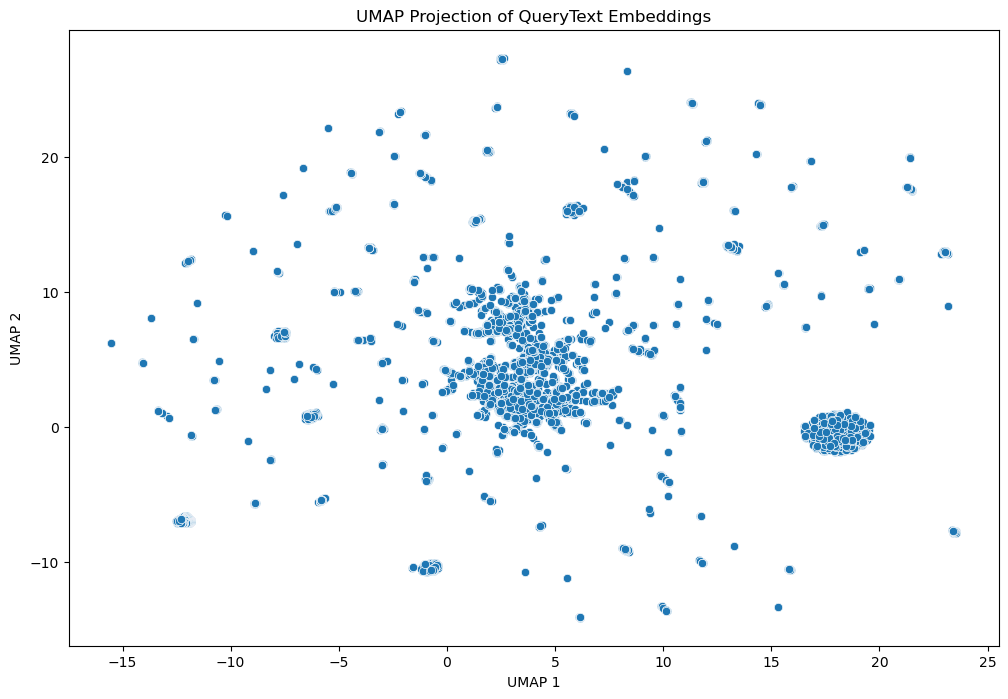

In [36]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce dimensions to 2D
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
embedding_2d = umap_model.fit_transform(QT['embedding'].tolist())

# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x=embedding_2d[:, 0], y=embedding_2d[:, 1])
plt.title("UMAP Projection of QueryText Embeddings")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()


In [38]:
from sklearn.cluster import KMeans
# Choose a number of clusters (you can tune this later)
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
QT['cluster'] = kmeans.fit_predict(QT['embedding'].tolist())

# View some samples per cluster
for i in range(n_clusters):
    print(f"\n--- Cluster {i} ---")
    print(QT[QT['cluster'] == i]['QueryText'].head(3).tolist())


--- Cluster 0 ---
['Asked about Government Schemes', 'Asked about PMFBY', 'Asked about PMKISAN']

--- Cluster 1 ---
['Asked about PM kisan samman nidhi yojana', 'Asked about PM kisan samman nidhi yojana- fruit ID creation', 'Asked about PM kisan status.']

--- Cluster 2 ---
['Asked about weather for irrigation', 'Farmer asked query on Weather', 'Farmer asked query on Weather']

--- Cluster 3 ---
['Asked about  general information', 'Asked about general information', 'Asked about General information']

--- Cluster 4 ---
['Asked about Market rate of redgram', 'Asked about Market information', 'Asked about market rate of Red gram']

--- Cluster 5 ---
['Asked about 2023-2024 crop insurance claim', 'Asked about PMFBY crop insurance claim status', 'Asked about PMFBY crop insurance claim']

--- Cluster 6 ---
['papaya sowing time ?', 'Asked about measures to control folded leaves and lack of growth in arecanut', 'Asked about onion thrips control']

--- Cluster 7 ---
['Asked about fertilizer a

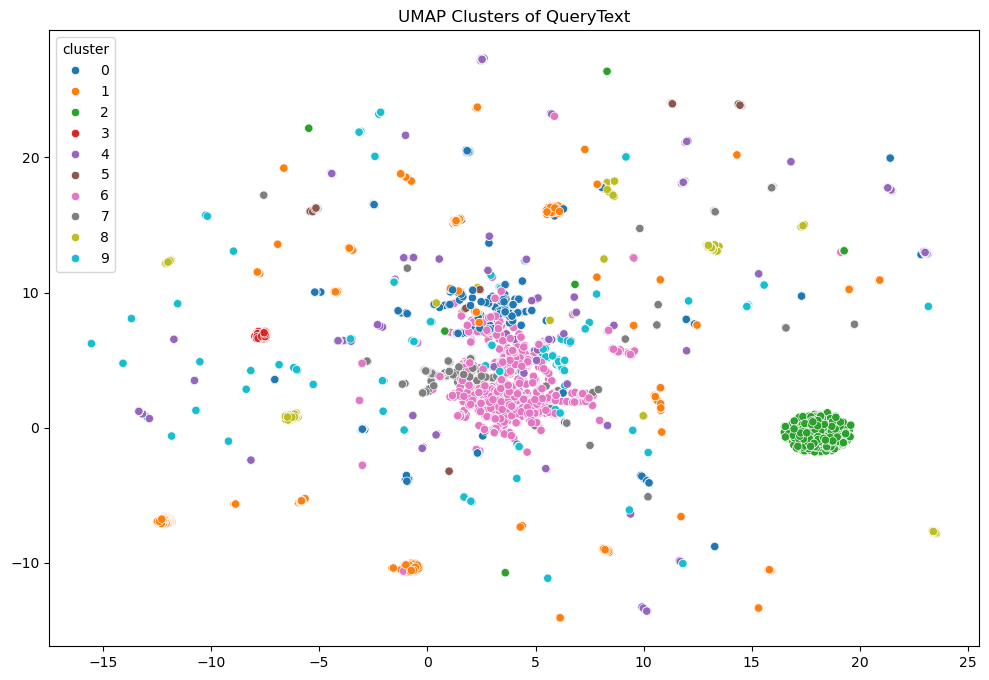

In [39]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=embedding_2d[:, 0], y=embedding_2d[:, 1], hue=QT['cluster'], palette='tab10', legend='full')
plt.title("UMAP Clusters of QueryText")
plt.show()

In [40]:
from sklearn.metrics.pairwise import cosine_similarity
def semantic_search(query, top_k=5):
    query_emb = model.encode([query])[0]
    similarities = cosine_similarity([query_emb], QT['embedding'].tolist())[0]
    top_indices = np.argsort(similarities)[::-1][:top_k]
    results = QT.iloc[top_indices][['QueryText']].copy()
    results['score'] = similarities[top_indices]
    return results

# Try searching
semantic_search("How to apply for PM Kisan Yojana?", top_k=5)

,QueryText,score
5270,Asked about procedure for applying PM Kisan Sa...,0.843680
5038,Asked about to application for PM Kisan Samman...,0.817466
8775,Asked about PM Kisan yojana instalments,0.811156
7084,Asked about PM KISAN yojana- new applicant,0.809807
4527,Asked about PM kisan yojana application status,0.806345


In [41]:
!pip install faiss-cpu


   ---------------------------------------- 0.0/15.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.0 MB ? eta -:--:--
    --------------------------------------- 0.3/15.0 MB ? eta -:--:--
   -- ------------------------------------- 0.8/15.0 MB 1.6 MB/s eta 0:00:09
   -- ------------------------------------- 0.8/15.0 MB 1.6 MB/s eta 0:00:09
   -- ------------------------------------- 1.0/15.0 MB 1.4 MB/s eta 0:00:10
   ---- ----------------------------------- 1.6/15.0 MB 1.4 MB/s eta 0:00:10
   ----- ---------------------------------- 2.1/15.0 MB 1.6 MB/s eta 0:00:09
   ------ --------------------------------- 2.4/15.0 MB 1.7 MB/s eta 0:00:08
   ------ --------------------------------- 2.6/15.0 MB 1.5 MB/s eta 0:00:09
   -------- ------------------------------- 3.1/15.0 MB 1.6 MB/s eta 0:00:08
   --------- ------------------------------ 3.4/15.0 MB 1.6 MB/s eta 0:00:08
   --------- ------------------------------ 3.7/15.0 MB 1.7 MB/s eta 0:00:07
   ---------- ------

In [42]:
import faiss

dimension = len(QT['embedding'].iloc[0])
index = faiss.IndexFlatL2(dimension)

# Convert to np.array for FAISS
embedding_matrix = np.vstack(QT['embedding'].values)
index.add(embedding_matrix)

# Save the index
faiss.write_index(index, "querytext_index.faiss")

# Optionally save mapping
QT[['QueryText']].to_csv("querytext_lookup.csv", index=False)


In [43]:
def search_faiss(query, top_k=5):
    query_emb = model.encode([query])
    distances, indices = index.search(query_emb, top_k)
    results = QT.iloc[indices[0]].copy()
    results['distance'] = distances[0]
    return results

search_faiss("Weather for papaya crop", top_k=5)


,QueryText,embedding,cluster,distance
5117,"ASKED ABOUT PLANTING TIME , VARIETIES FOR PAPAYA","[0.015309607610106468, 0.040212735533714294, -...",6,0.546610
12269,Asked about Varieties of PAPAYA,"[0.04195398837327957, 0.008454650640487671, -0...",6,0.669271
0,papaya sowing time ?,"[-0.0028699631802737713, 0.021032867953181267,...",6,0.689776
14225,Asked about General information on sowing time...,"[0.03023521602153778, 0.03993820771574974, -0....",6,0.690634
10476,Asked about varieties of papaya.,"[0.037713129073381424, 0.024184010922908783, -...",6,0.706765
